# Tutorial 1: Cell Sentence Conversion & Reconstruction
In this tutorial, we will explore one of the key concepts in the Cell2Sentence (C2S) framework: the transformation of single-cell RNA sequencing data into what we call 'cell sentences.' These cell sentences are sequences of gene names ordered by their expression levels within each cell. This transformation allows us to leverage Large Language Models (LLMs) for single-cell biology in a flexible way, and take advantage of their natural language capabilities and large-scale pretraining.

We will also demonstrate how to reconstruct the original gene expression vectors from these cell sentences using a simple linear model. This process is important for validating that the information encoded in the cell sentences can be effectively decoded back into its original form without losing too much information.

- **Dataset Information**:
  - Source: Immune System tissue dataset from Domínguez Conde et al. (2022)
  - Link: [Science Article](https://www.science.org/doi/full/10.1126/science.abl5197)
  - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
- Subset Used: Two donors (A29 and A31), totaling 29,773 cells.
- **Preprocessing**: The data was preprocessed in Tutorial 0 (Data Preparation). We will start with this preprocessed data in this tutorial.

First, we will import the necessary libraries. These include general-purpose Python libraries, as well as specialized libraries for single-cell RNA sequencing data analysis.

In [47]:
# Python built-in libraries
import os
import random
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.utils import benchmark_expression_conversion, reconstruct_expression_from_cell_sentence

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the previous tutorial. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,assay,sex,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,10x 5' v1,female,2191,2191,6542.0,327.0,4.998472
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female,2046,2046,5871.0,429.0,7.307103
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female,2129,2129,7248.0,337.0,4.649559
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female,1262,1262,3927.0,305.0,7.766743
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,10x 5' v1,female,2248,2248,6574.0,1083.0,16.473988


In [6]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


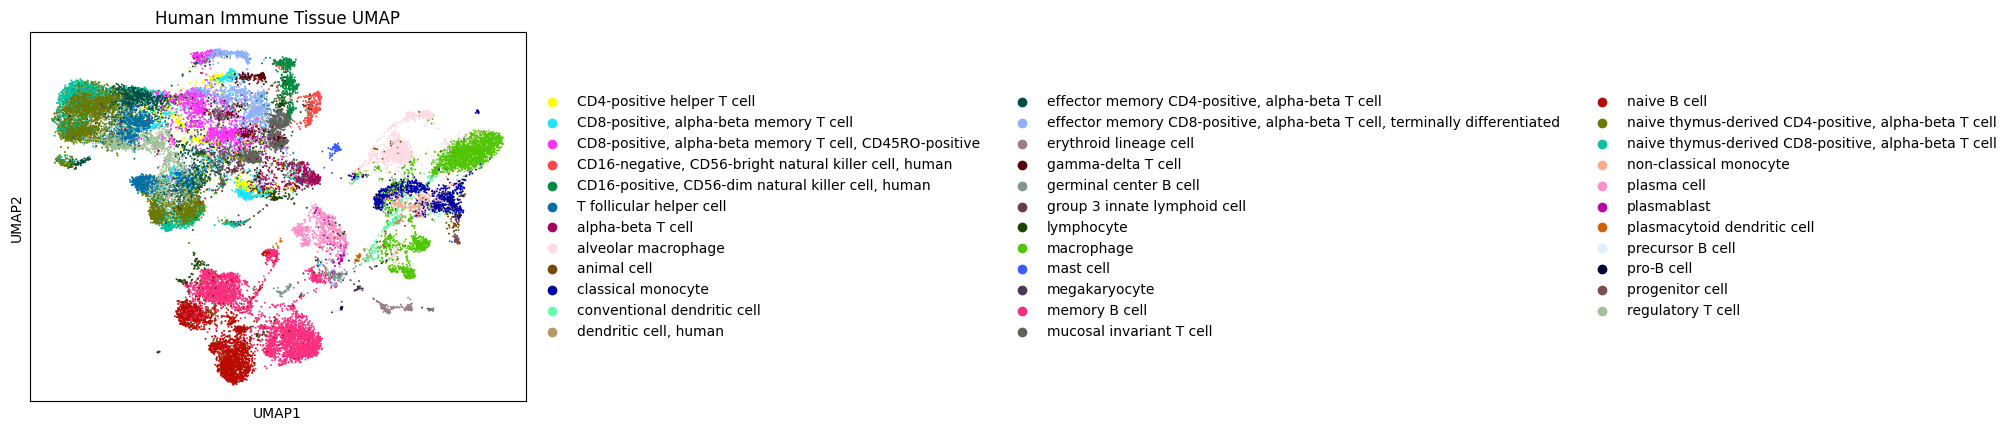

In [7]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [8]:
adata.X.max()

3.408124

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

Now that we have preprocessed and normalized data loaded, we will perform the conversion to cell sentences. In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

First, we define which columns in adata.obs we would like to keep in our C2S dataset. Cell type, tissue, donor, organism, and sex information will be useful to keep, so we will define a list with these labels:

In [9]:
adata_obs_cols_to_keep = ["cell_type", "tissue", "batch_condition", "organism", "sex"]

Now, we create a CSData object using the adata_to_arrow() class function of the CSData model class. This will return us a Huggingface PyArrow dataset (see https://huggingface.co/docs/datasets/en/about_arrow)

In [10]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:11<00:00, 2503.84it/s]


Let's examine the arrow dataset which was created:

In [11]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

We can see that our 29,773 cells have now been converted into rows of a Dataset object. The metadata columns of our adata object have been preserved, and two new columns have been added: cell_name and cell_sentence. These columns contain unique cell identifiers as well as cell sentences, respectively. Each cell sentence consists of a string of space-separated gene names, in order of descending expression value. For more details about the cell sentence creation process, please refer to the [C2S paper](https://www.biorxiv.org/content/10.1101/2023.09.11.557287v3).

We can look at one arrow dataset example as follows:

In [12]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

When we print out an entire sample, we can see that it is a Python dictionary. The cell sentence contains a sentence of gene names ordered by descending expression level, giving a rank-based gene name representation of the cell. The rest of the columns of adata.obs which were specified also show up in the dataset sample.

This dataset format will allow us to work with cell sentence datasets in an efficient manner. For more details on the cell sentence transformation, please review the Cell2Sentence paper:
https://openreview.net/pdf?id=EWt5wsEdvc

In [13]:
len(arrow_ds[sample_idx]["cell_sentence"].split(" "))  # Cell 0 has 2191 nonzero expressed genes, yielding a sentence of 2191 gene names separated by spaces.

2191

Next, we will examine the vocabulary which was generated:

In [14]:
print(type(vocabulary))
print(len(vocabulary))

<class 'collections.OrderedDict'>
23944


We can see that vocabulary is an OrderedDict of gene features, corresponding to the original 23944 genes in our adata object. The OrderedDict denotes the gene features present in our single-cell dataset, and also stores the number of cells that gene was expressed in.

In [15]:
list(vocabulary.items())[:10]

[('RP11-34P13', 38),
 ('RP11-34P13-3', 106),
 ('AP006222', 7),
 ('LINC01409', 1292),
 ('FAM87B', 3),
 ('LINC01128', 1849),
 ('LINC00115', 562),
 ('FAM41C', 225),
 ('LINC02593', 4),
 ('SAMD11', 11)]

# CSData creation

Now that our AnnData object is converted into an arrow dataset, we can create a CSData object to wrap around our arrow dataset. This will help us manage the arrow dataset, keeping it saved on disk and out of memory until we need the data for inference or finetuning.

In [16]:
c2s_save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "dominguez_immune_tissue_tutorial1"  # This will be the name of our C2S dataset on disk

In [17]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 29773/29773 [00:00<00:00, 62307.10 examples/s] 


In [18]:
print(csdata)

CSData Object; Path=/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2, Format=arrow


The csdata object simply saves our arrow dataset onto disk and keeps a reference to the path. This wrapper class will work in concert with other classes such as CSModel and task functions to load the dataset whenever necessary, so that we avoid holding the C2S dataset in memory when it is not necessary.

We can retrieve and view cell sentences by calling the get_sentence_strings() function:

In [19]:
cell_sentences_list = csdata.get_sentence_strings()

In [20]:
len(cell_sentences_list)

29773

In [21]:
def print_first_N_genes(cell_sentence_str: str, top_k_genes: int, delimiter: str = " "):
    """Helper function to print K genes of a cell sentence."""
    print(delimiter.join(cell_sentence_str.split(delimiter)[:top_k_genes]))

In [22]:
print_first_N_genes(cell_sentences_list[0], top_k_genes=100)

RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14


In [23]:
print_first_N_genes(cell_sentences_list[1], top_k_genes=100)

TMSB4X MT-CO1 B2M MT-CO2 MALAT1 HSPA1A ACTB HSP90AA1 RPLP1 MT-CO3 MT-CYB RPS27 JUNB MT-ND3 EEF1A1 HSPA1B HLA-B RPL41 RPS18 CD69 DNAJB1 JUN CCL5 RPL10 RPL28 FOS MT-ND4L MT-ATP8 RPS19 IL32 TPT1 RPL39 IFNG RPL13 FTH1 PPP1R15A RPS15A RPS14 PFN1 ZFP36 HLA-C CD52 EIF1 SH3BGRL3 PTMA MT-ATP6 RPS12 FTL ACTG1 NR4A2 RPS3 RPS15 GAPDH RPLP2 RPL11 HLA-A RPS4X TNFAIP3 RPL34 RPL18 RPL32 RPL37 RPL30 MT-ND1 RPL8 RPL19 RPS23 RPL18A MT-ND2 GZMA UBC NKG7 RPL21 RPS21 RPS27A RPS28 RPL35A GADD45B H3-3B RPS24 RPL3 RPL29 RPS6 VIM SELENOK RPLP0 S100A4 RPL26 RPS13 CD8A MTRNR2L12 RPS25 CD3E CD3D RPS7 FAU CFL1 RPL12 DUSP1 RPS8


In [24]:
print_first_N_genes(cell_sentences_list[2], top_k_genes=100)

TMSB4X EEF1A1 RPLP1 B2M RPL41 RPL10 HSPA1A ACTB MALAT1 HSP90AA1 RPL32 FOS DNAJB1 RPS27 RPS12 RPS19 MT-CO1 TPT1 MT-CO2 RPS18 RPL28 RPL34 CCL5 RPL13 RPL37 RPS6 RPS15A HLA-B RPS3 RPS4X RPS2 RPL11 MT-ND3 RPS14 MT-CO3 RPL39 RPS3A RPL30 MT-CYB RPL21 RPLP0 HSPA1B RPL18A DUSP1 RPL26 RPS23 RPL19 RPS13 HSPA8 VIM RPL3 RPS15 RPS21 FTH1 RPL29 RPL12 RPS27A RPL8 BTG1 RPS28 HLA-C RPLP2 MT-ND4L RPS7 RPL18 RPL7A EIF1 RPS8 RPL15 XCL1 SRGN RPS25 FAU SH3BGRL3 RPL17 MT-ATP8 UBC RPS29 RPL36 RACK1 RPL23A RPL6 ACTG1 IFITM1 JUN RPL13A PFN1 RPL14 RPL36A PTMA RPL37A RPL9 MT-ND2 RPS24 FOSB KLF6 IFITM2 MT-ND5 HLA-A HLA-E


# Cell Sentence Transformation Benchmarking

We have successfully converted our single-cell dataset into cell sentences using the conversion functions, however it would be useful to know how well the conversion did, and how much expression information was lost when we switched to a rank ordering of genes rather than exact expression values.

In the [C2S paper](https://www.biorxiv.org/content/10.1101/2023.09.11.557287v3), a strong linear relationship was found between the log of the rank of a gene and its normalized expression value. We can similarly examine our rank transformation and reconstruction ability of the original expression by calling a rank transformation benchmarking utility function. This function will:
1. Fit a linear model on the ranks and expression of the original data, which can be used to reconstruct expression from rank
2. Save plots of log rank vs log expression and log expression vs reconstructed expression from rank

First, we define a path where the plots for the benchmarking and reconstruction will be saved:

In [25]:
output_path = os.path.join(c2s_save_dir, c2s_save_name)
output_path

'/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2'

In [27]:
transformation_benchmarking_save_name = "inverse_transformation_testing_tutorial_2"

We can call the benchmarking function with our output directory, as well as the normalized expression of our AnnData object. To avoid benchmarking on too many data points, we set a sample_size of cells to benchmark the rank transformation on.

In [26]:
benchmark_expression_conversion(
    benchmark_output_dir=output_path,
    save_name=transformation_benchmarking_save_name,
    normalized_expression_matrix=adata.X,
    sample_size=1024,
)

Benchmarking with a sample dataset of size 1024


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2/inverse_transformation_testing_tutorial_2_benchmark/normalized_expression_vs_log_rank.png
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial2/inverse_transformation_testing_tutorial_2_benchmark/reconstructed_expression.png


Now, we can retrieve the slope and intercept of the linear model which was fit to predict expression from rank

In [28]:
metrics_df = pd.read_csv(os.path.join(output_path, transformation_benchmarking_save_name + "_benchmark", "c2s_transformation_metrics.csv"))
metrics_df.shape

(1, 11)

In [29]:
metrics_df

,experiment,x_axis,y_axis,threshold,slope,intercept,r_squared,pearson_r_statistic,pearson_r_pvalue,spearman_r_statistic,spearman_r_pvalue
0,Normalized Expression vs Log Rank,log_rank_normalized_expression,normalized_expression,3,-0.675689,2.237853,0.794836,0.929959,0.0,0.866874,0.0


We can see here the slope and intercept of the linear model which was fit on the log rank versus normalized expression on our sample of cells. Furthermore, we can see correlation statistics of the inverse reconstruction, where the linear model predicts the original expression based on the rank of the gene.

We can see that the linear model achieves 0.867 R^2, matching what was seen in the C2S paper. This indicates that most of the variance in the data is preserved when converting to rank-ordered cell sentences and then recovering the expression from rank. This allows us to utilize cell sentences and LLMs without worry about losing too much information when converting back to expression.

In [30]:
slope = metrics_df.iloc[0]["slope"]
intercept = metrics_df.iloc[0]["intercept"]
print("slope:", slope)
print("intercept:", intercept)

slope: -0.6756886579917628
intercept: 2.237853249084892


# Reconstruct Cell Expression From Cell Sentences

To further see the ability of the linear model to reconstruct original gene expression from rank in the cell sentences, in this section we will reconstruct expression vectors from cell sentences and visualize them against the original data.

First, we need to create a list of the gene names in our vocabulary. This will determine the ordering of genes in the expression vector we reconstruct:

In [33]:
vocab_list = list(vocabulary.keys())
print(len(vocab_list))
vocab_list[:4]

23944


['RP11-34P13', 'RP11-34P13-3', 'AP006222', 'LINC01409']

Now, we will first reconstruct a single expression vector:

In [32]:
print(len(cell_sentences_list))
print_first_N_genes(cell_sentences_list[0], top_k_genes=100)

29773
RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14


In [34]:
expression_vector = reconstruct_expression_from_cell_sentence(
    cell_sentence_str=cell_sentences_list[0],
    delimiter=" ",
    vocab_list=vocab_list,
    slope=slope,
    intercept=intercept,
)

In [35]:
print(type(expression_vector))
print(expression_vector.shape)
print(expression_vector.dtype)

<class 'numpy.ndarray'>
(23944,)
float32


In [38]:
expression_vector

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [37]:
expression_vector.sum()

599.0824

In [40]:
print(len(cell_sentences_list[0].split(" ")))
print(np.nonzero(expression_vector)[0].shape)

2191
(2191,)


We can see that the function reconstruct_expression_from_cell_sentence() has performed the inverse reconstruction on the cell sentence, using the rank of each gene in the cell sentence to predict its original expression using the linear model we fitted earlier:
- predicted_expression = intercept + (slope * log(rank_of_gene))

We can now repeat this and reconstruct the entire original dataset:

In [43]:
all_reconstructed_expression_vectors = []
for idx in tqdm(range(len(cell_sentences_list))):
    expression_vector = reconstruct_expression_from_cell_sentence(
        cell_sentence_str=cell_sentences_list[idx],
        delimiter=" ",
        vocab_list=vocab_list,
        slope=slope,
        intercept=intercept,
    )
    all_reconstructed_expression_vectors.append(expression_vector)

all_reconstructed_expression_vectors = np.stack(all_reconstructed_expression_vectors)

100%|██████████| 29773/29773 [01:27<00:00, 339.96it/s]


In [44]:
all_reconstructed_expression_vectors.shape

(29773, 23944)

Let's now make a new AnnData object, copying the .obs and .var from our original adata, but putting in our reconstructed expression vectors

In [48]:
all_reconstructed_expression_vectors = scipy.sparse.csr_array(all_reconstructed_expression_vectors)
all_reconstructed_expression_vectors

<29773x23944 sparse array of type '<class 'numpy.float32'>'
	with 48389984 stored elements in Compressed Sparse Row format>

In [50]:
reconstructed_adata = anndata.AnnData(
    X=all_reconstructed_expression_vectors,
    obs=adata.obs.copy(),
    var=adata.var.copy()
)
reconstructed_adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Quickly verify that the original adata.var gene list ordering matches the vocab_list which we reconstructed vectors with:

In [51]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


In [52]:
vocab_list[:5]

['RP11-34P13', 'RP11-34P13-3', 'AP006222', 'LINC01409', 'FAM87B']

# Plotting Reconstructed Expression Vectors

Now we will plot original data and reconstructed expression vectors side by side, to verify that the cell sentence transformation has preserved most of the original variance of the data.

First, we will remove the extra attributes of our original adata object, since we will need to create a new joint UMAP.

In [53]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp

In [54]:
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [55]:
adata.obs["c2s_data_label"] = ["Original Data"] * adata.obs.shape[0]
reconstructed_adata.obs["c2s_data_label"] = ["Reconstructed From Cell Sentences"] * reconstructed_adata.obs.shape[0]

In [56]:
combined_adata = anndata.concat([adata, reconstructed_adata], axis=0)
combined_adata

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 59546 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'c2s_data_label'

In [57]:
combined_adata.obs_names_make_unique()

In [58]:
combined_adata.var = adata.var.copy()

In [62]:
combined_adata.obs = combined_adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex", "c2s_data_label"]]

In [63]:
combined_adata

AnnData object with n_obs × n_vars = 59546 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex', 'c2s_data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [64]:
combined_adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex,c2s_data_label
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female,Original Data
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female,Original Data
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female,Original Data
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female,Original Data
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female,Original Data


In [65]:
combined_adata.obs.tail()

,cell_type,tissue,batch_condition,organism,sex,c2s_data_label
Pan_T7935489_TTCTCCTCATCCAACA-1,"CD8-positive, alpha-beta memory T cell",sigmoid colon,A29,Homo sapiens,female,Reconstructed From Cell Sentences
Pan_T7935489_TTGAACGAGTTGTCGT-1,T follicular helper cell,sigmoid colon,A29,Homo sapiens,female,Reconstructed From Cell Sentences
Pan_T7935489_TTGAACGCACGCCAGT-1,group 3 innate lymphoid cell,sigmoid colon,A29,Homo sapiens,female,Reconstructed From Cell Sentences
Pan_T7935489_TTGTAGGAGGGCATGT-1,germinal center B cell,sigmoid colon,A29,Homo sapiens,female,Reconstructed From Cell Sentences
Pan_T7935489_TTTACTGGTTGTGGCC-1,"effector memory CD8-positive, alpha-beta T cel...",sigmoid colon,A29,Homo sapiens,female,Reconstructed From Cell Sentences


In [66]:
combined_adata.X.max()

3.408124

We can now run PCA, Scanpy's neighbors algorithm, and then the UMAP algorithm:

In [67]:
sc.tl.pca(combined_adata)

In [68]:
sc.pp.neighbors(combined_adata)

In [69]:
sc.tl.umap(combined_adata)

In [70]:
combined_adata

AnnData object with n_obs × n_vars = 59546 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex', 'c2s_data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [71]:
combined_adata[combined_adata.obs["c2s_data_label"] == "Reconstructed From Cell Sentences", :]

View of AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex', 'c2s_data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


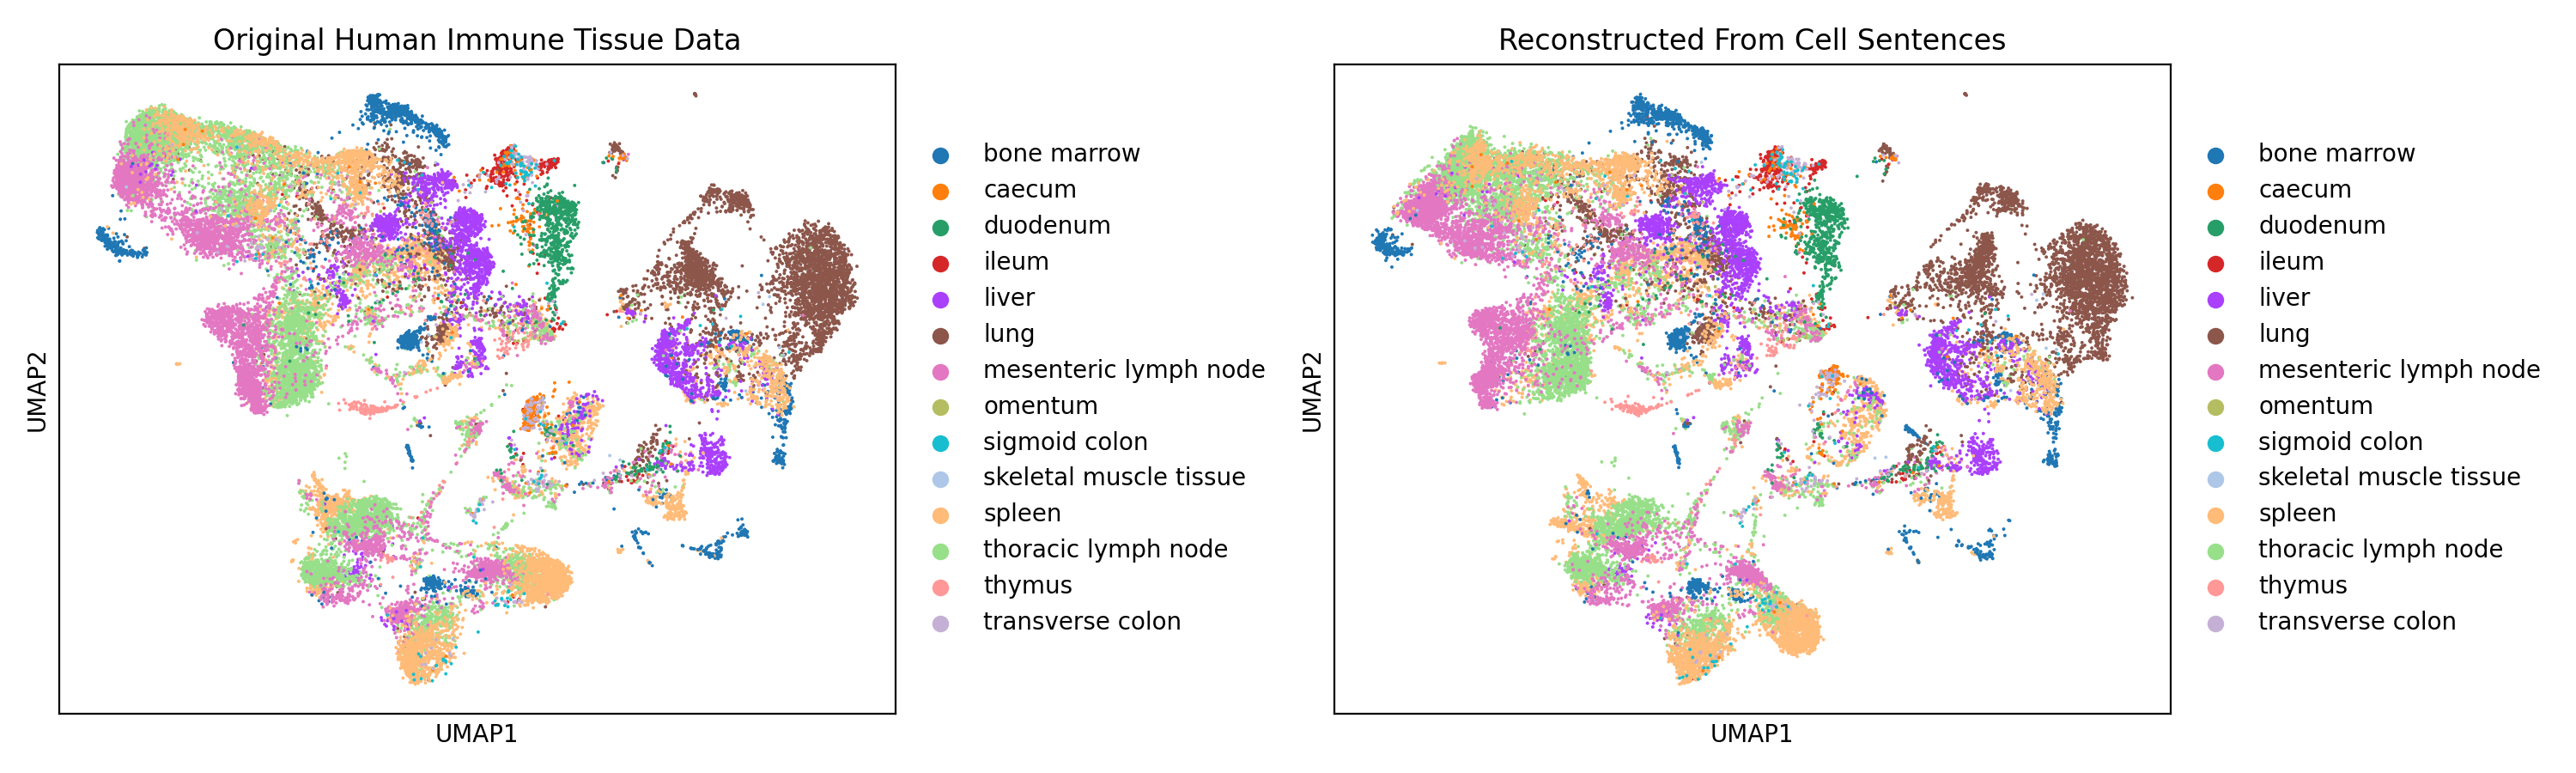

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))
sc.pl.umap(
    combined_adata[combined_adata.obs["c2s_data_label"] == "Original Data", :],
    color="tissue",
    size=8,
    title="Original Human Immune Tissue Data",
    show=False,
    ax=ax1
)
sc.pl.umap(
    combined_adata[combined_adata.obs["c2s_data_label"] == "Reconstructed From Cell Sentences", :],
    color="tissue",
    size=8,
    title="Reconstructed From Cell Sentences",
    show=False,
    ax=ax2
)
plt.tight_layout()
plt.show()
plt.close()

We can see that our conversion to cell sentences and back to expression vectors has preserved the structure of the data, due to the accuracy of the linear model in predicting expression from the rank information. This means we can train LLMs and perform single-cell tasks with them, and once we have predicted cell sentences, we can always convert them back to expression vectors whenever necessary for further analysis!